### Trabalho Final - Análise de Dados com Python

Integrantes:

    1) ALBERT MAZUZ                         RM 349663
    2) OTÁVIO AUGUSTO FERRARI PEDRO         RM 350448
    3) PEDRO AUGUSTO FERREIRA DE ALMEIDA    RM 348801
    4) WILLIAM REIS DE ARAUJO               RM 348868

### Enunciado
O departamento de crédito da QuantumFinance solicitou a criação de um algoritmo para predizer o valor dos imóveis em determinada região a fim de mensurarem a provisão de crédito para o próximo ano. Assim, baseado no dataset disponível, use Regressão Linear Multivariada para predizer o valor dos imóveis com um RMSE abaixo de 69000. [dataset](https://github.com/ageron/handson-ml2/tree/master/datasets/housing)

### IMPORTAÇÃO E TRATAMENTO DOS DADOS

In [1]:
# Imortar Bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
# Carregar base de dados (Manter a base de dados na mesma pasta que este arquivo, pois assim não será necessário informar a localização do mesmo)
data = pd.read_csv("housing.csv")

In [3]:
# A coluna "ocean_proximity" é categórica, então para poder utilizá-la no modelo preditivo, vamos dividir essa coluna em outras 
# (correspondentes a suas categorias, NEAR OCEN, NEAR BAY, etc), com valores 1 = True e 0 = False
data_ajustada = pd.concat([data.drop('ocean_proximity', axis=1),
                           pd.get_dummies(data['ocean_proximity'])], axis=1)

In [4]:
# Verificar características da base ajustada
data_ajustada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   <1H OCEAN           20640 non-null  bool   
 10  INLAND              20640 non-null  bool   
 11  ISLAND              20640 non-null  bool   
 12  NEAR BAY            20640 non-null  bool   
 13  NEAR OCEAN          20640 non-null  bool   
dtypes: bool(5), float64(9)
memory usage: 1.5 MB


In [5]:
# Ao carregar as características da base, nota-se que há 210 itens (aproximadamente 1% da base) sem o campo "total_rooms" preenchido.
# Neste caso, vamos remover as linhas sem o campo "total_rooms" preenchido
data_ajustada.dropna(inplace=True)

In [6]:
# Separando as features (X) e o target (y)
X = data_ajustada.drop(['median_house_value'], axis=1)
y = data_ajustada['median_house_value']

In [7]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

### ANÁLISE EXPLORATÓRIA

In [8]:
# Avaliação dos dados de treino após os ajustes realizados
data_ajustada.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


In [9]:
#Verificando as variáveis numéricas
data_ajustada.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
# Calculando a matriz de correlação - Ao executar este comando, percebemos que a Proximidade do Oceano e Total de Cômodos são as variáveis que mais influenciam no valor
# do imóvel, enquanto que variáveis como Total da População e Total de Quartos então entre as variáveis menos influentes
train = X_train.join(y_train)
corr_mat = train.corr()
corr_mat['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688306
<1H OCEAN             0.254339
NEAR BAY              0.164116
NEAR OCEAN            0.144984
total_rooms           0.138462
housing_median_age    0.104762
households            0.067366
total_bedrooms        0.051768
ISLAND                0.026670
population           -0.022202
longitude            -0.045989
latitude             -0.146191
INLAND               -0.488870
Name: median_house_value, dtype: float64

<Axes: >

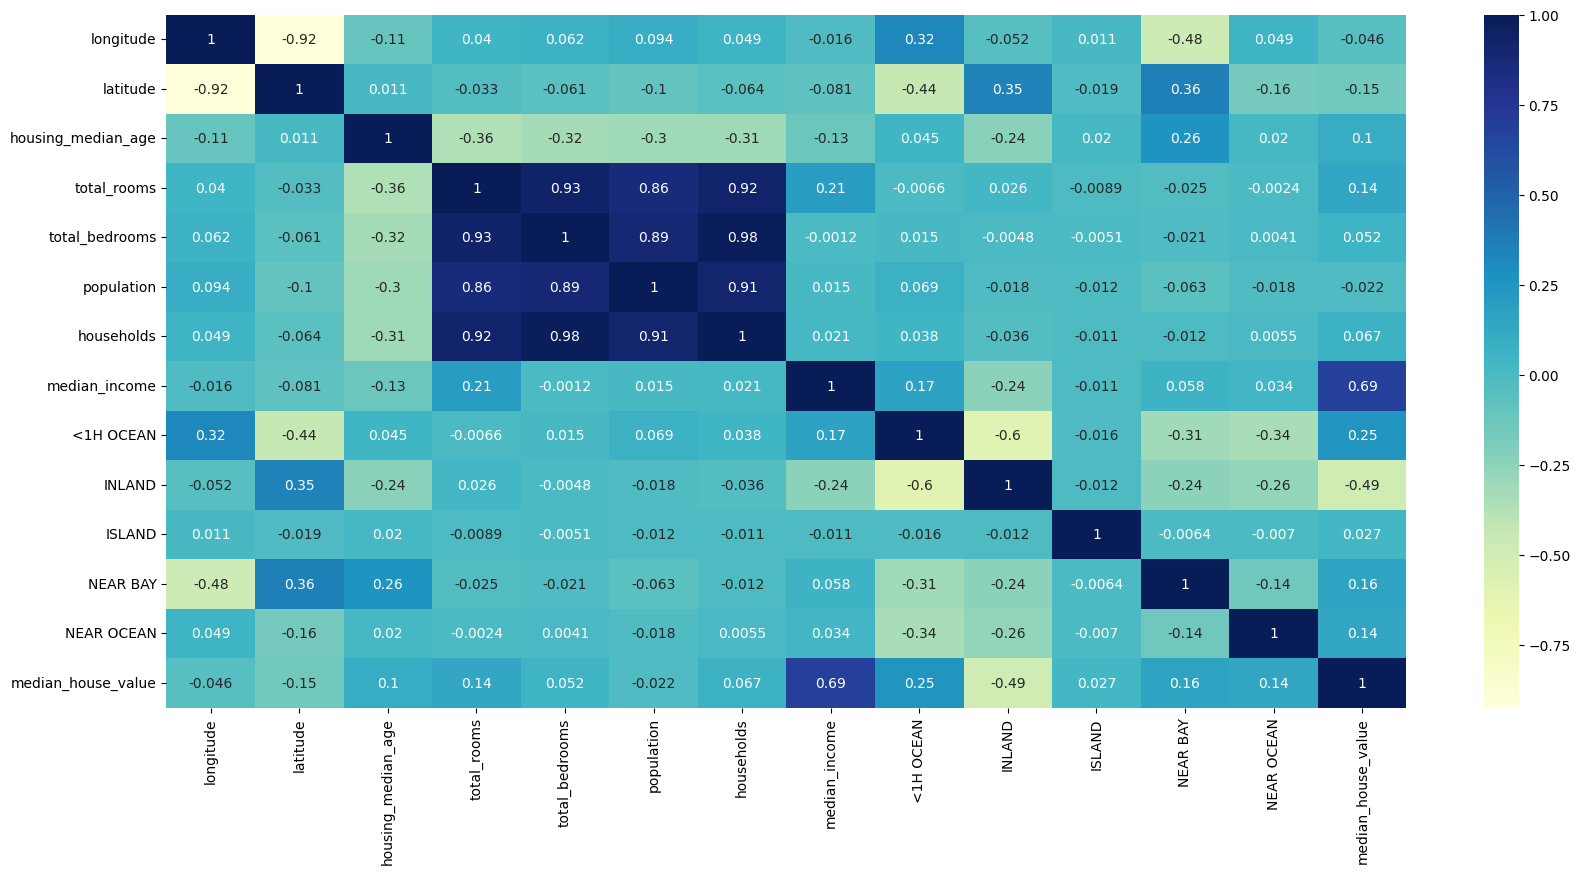

In [11]:
# Criando um gráfico de calor para a matriz de correlação
plt.figure(figsize=(20,9))
sns.heatmap(train.corr(), annot=True, cmap="YlGnBu")

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

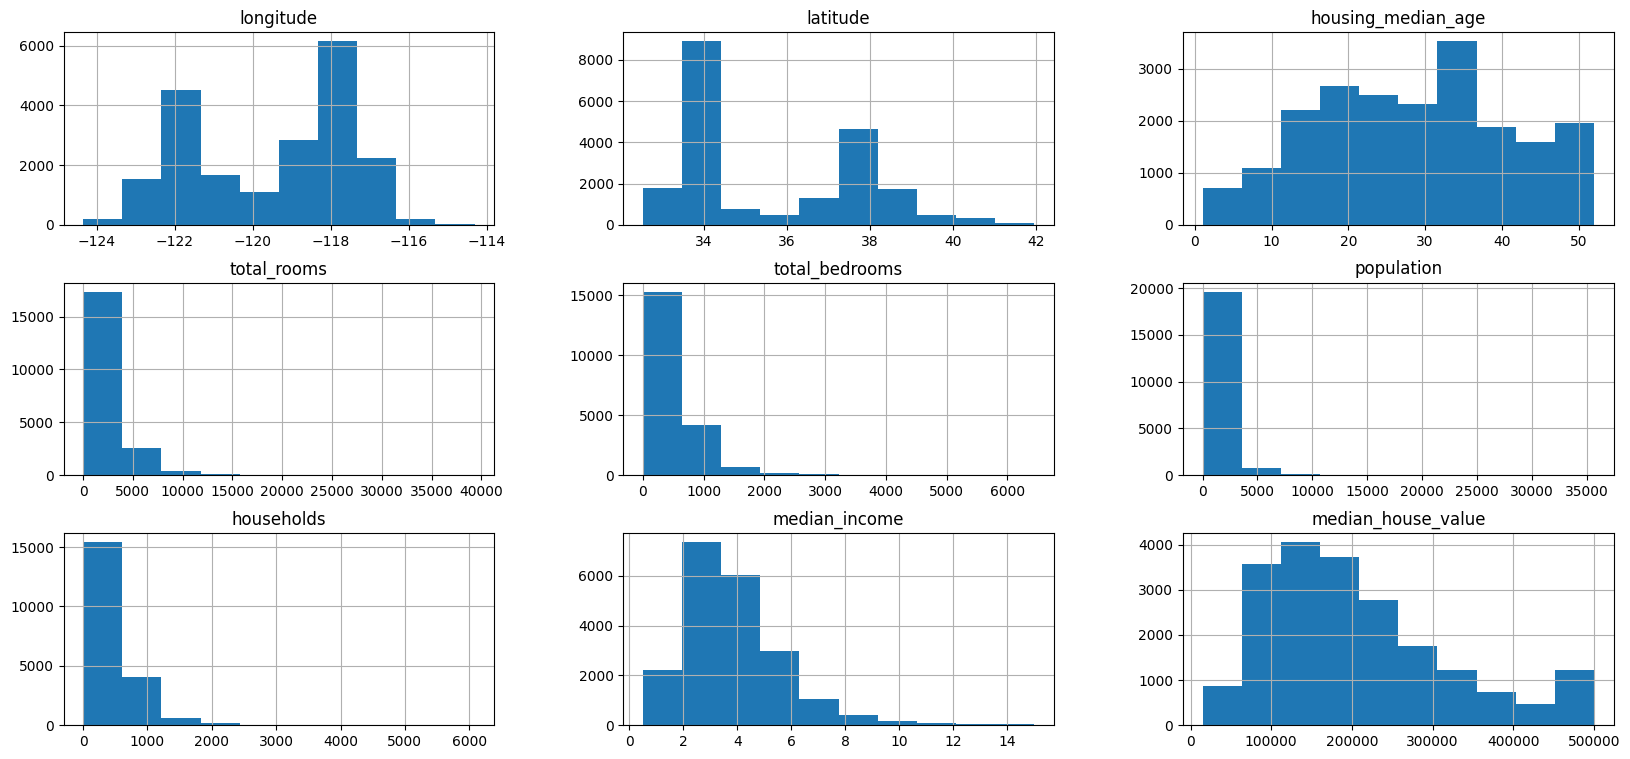

In [12]:
#Histograma das variáveis
data_ajustada.hist(figsize=(20,9))

### Criação do Pipeline

In [13]:
# Criando um pipeline para o pré-processamento dos dados
pipeline = Pipeline([('std_scaler', StandardScaler()),
                    ('poly_features', PolynomialFeatures(degree = 2))])

In [14]:
# Aplicando o pipeline aos dados
data_preparada = pipeline.fit_transform(X)

### Criação do Modelo e Previsão dos Resultados

In [15]:
# Criação, Treinamento e Avaliação do modelo de regressão linear
Rl = LinearRegression()
Rl.fit(data_preparada, y)
Rl.score(data_preparada, y)

0.7138996539259703

In [16]:
# Fazendo previsões para a base de testes
predictions = Rl.predict(data_preparada)

In [17]:
# Calculando o erro quadrático médio (MSE)
mse = mean_squared_error(predictions, y)

In [18]:
# Calculando a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
rmse

61743.121370669345